In [1]:
from qiskit import QuantumCircuit

def build(circuit_width, hidden_bitstring) -> QuantumCircuit:
    # Create circuit, reserving one qubit for BV oracle
    bv_circuit = QuantumCircuit(circuit_width + 1, circuit_width)
    bv_circuit.x(circuit_width)
    bv_circuit.h(range(circuit_width + 1))
    for input_qubit, bit in enumerate(reversed(hidden_bitstring)):
        if bit == "1":
            bv_circuit.cx(input_qubit, circuit_width)
    bv_circuit.barrier()
    bv_circuit.h(range(circuit_width + 1))
    bv_circuit.barrier()
    for input_qubit in range(circuit_width):
        bv_circuit.measure(input_qubit, input_qubit)
    return bv_circuit

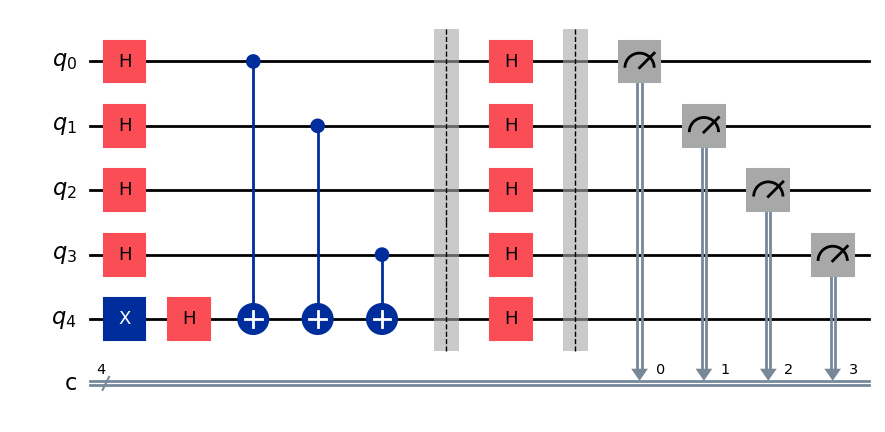

In [2]:
circuit_width = 4
hidden_bitstring = "1011"
bv_circuit = build(circuit_width, hidden_bitstring)
bv_circuit.draw(output='mpl')

In [ ]:
#need ibm api token to access backend
from qiskit import transpile
transpiled_circuit = transpile(bv_circuit, backend=backend, scheduling_method='asap', optimization_level=2, seed_transpiler=1234)
transpiled_circuit.draw(output='mpl')

In [ ]:
# The transpiled circuit includes all the qubits from the QPU, but we only need the active one
transpiled_circuit.qubits
truncated_circuit, old_to_new = remove_idle_qubits(transpiled_circuit)
print(f"The indices mapping from the original circuit to the truncated circuit is: {old_to_new}")
truncated_circuit.draw(output='mpl')

In [ ]:
from math import sqrt, cos, sin, tau
import matplotlib.pyplot as plt
import networkx as nx

G = nx.Graph()
nodes = old_to_new.values()
edges = [
    tuple(sorted((u, v)))
    for u, v in active_edges
]
G.add_nodes_from(nodes)
G.add_edges_from(edges)

fig, ax = plt.subplots(figsize=(4, 4))
pos = nx.spring_layout(
    G, seed=42, k=1 / sqrt(len(nodes)) / 24, scale=0.5
)
# Pull isolated nodes toward the cluster centroid
isolates = [n for n, deg in G.degree() if deg == 0]
if isolates:
    non_isolates = [n for n in G.nodes() if n not in isolates]
    if non_isolates:
        cx = sum(pos[n][0] for n in non_isolates) / len(non_isolates)
        cy = sum(pos[n][1] for n in non_isolates) / len(non_isolates)
        radius = (1 / sqrt(len(nodes))) / 6
        for i, n in enumerate(isolates):
            angle = (i / max(1, len(isolates))) * tau
            pos[n] = (cx + radius * cos(angle), cy + radius * sin(angle))

nx.draw(G, pos, with_labels=True, node_size=500, font_weight="bold", ax=ax)
fig.tight_layout()

In [ ]:
from pathlib import Path
import qiskit.qasm3 as qasm3

qasm3_str = qasm3.dumps(truncated_circuit)
Path("bv-4-5.qasm").write_text(qasm3_str)

In [5]:
from qiskit import QuantumRegister, ClassicalRegister

def remove_idle_qubits(
    circuit: QuantumCircuit,
    idle_operations: set[str] | None = None,
) -> tuple[QuantumCircuit, dict[int, int]]:
    """
    Remove qubits that only have idle operations (e.g., delay, barrier) from the
    circuit.

    This is particularly useful for circuits loaded from QASM files that include many
    unused physical qubits.

    Args:
        circuit: The input quantum circuit
        idle_operations: Set of operation names considered "idle". Defaults to
        {"delay", "barrier"}

    Returns:
        A tuple of (filtered_circuit, old_to_new_index_map) where:
        - filtered_circuit: New circuit with only active qubits
        - old_to_new_index_map: Mapping from old qubit indices to new contiguous indices

    Example:
        If the original circuit has qubits [0, 1, ..., 155] but only qubits
        [130, 131, 132, 138, 151] are active, the new circuit will have 5 qubits
        indexed [0, 1, 2, 3, 4] and the map will be {130: 0, 131: 1, 132: 2, 138: 3,
        151: 4}
    """
    if idle_operations is None:
        idle_operations = {"delay", "barrier"}

    # Find qubits that have at least one non-idle operation
    active_qubits = set()
    for inst in circuit.data:
        op_name = inst.operation.name
        if op_name not in idle_operations:
            for qb in inst.qubits:
                qubit_idx = circuit.qubits.index(qb)
                active_qubits.add(qubit_idx)

    if not active_qubits:
        # No active qubits, return empty circuit
        return QuantumCircuit(), {}

    # Create mapping from old indices to new contiguous indices
    sorted_active = sorted(active_qubits)
    old_to_new = {old_idx: new_idx for new_idx, old_idx in enumerate(sorted_active)}

    # Create new circuit with only active qubits
    new_qreg = QuantumRegister(len(sorted_active), "q")

    # Handle classical bits if present
    if circuit.num_clbits > 0:
        new_creg = ClassicalRegister(circuit.num_clbits, "c")
        new_circuit = QuantumCircuit(new_qreg, new_creg)
    else:
        new_circuit = QuantumCircuit(new_qreg)

    # Copy over instructions, remapping qubits
    for inst in circuit.data:
        op = inst.operation

        # Check if all qubits in this instruction are active
        qubit_indices = [circuit.qubits.index(qb) for qb in inst.qubits]
        if not all(idx in old_to_new for idx in qubit_indices):
            # Skip instructions on idle qubits
            continue

        # Remap qubits to new indices
        new_qargs = [new_qreg[old_to_new[idx]] for idx in qubit_indices]

        # Handle classical bits
        new_cargs = []
        if inst.clbits and circuit.num_clbits > 0:
            for cb in inst.clbits:
                clbit_idx = circuit.clbits.index(cb)
                new_cargs.append(new_circuit.clbits[clbit_idx])

        new_circuit.append(op, new_qargs, new_cargs)

    return new_circuit, old_to_new

def get_active_edges(circuit: QuantumCircuit, old_to_new: dict[int, int], backend) -> list[tuple[int, int]]:
    layout_dict = circuit.layout.initial_layout.get_virtual_bits()
    active_physical_qubits = [
        phys
        for virt, phys in layout_dict.items()
        if hasattr(virt, "_register") and virt._register.name == "q"
    ]

    coupling = backend.configuration().coupling_map
    active_edges = [
        [old_to_new[edge[0]], old_to_new[edge[1]]]
        for edge in coupling
        if edge[0] in active_physical_qubits and edge[1] in active_physical_qubits
    ]
    return active_edges